In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4
depth = 9    ##using d = (D+1)*S
d = 40

In [3]:
dev = qml.device("default.qubit", wires=numQubits)

In [4]:
iris = datasets.load_iris()
X = iris.data[:, :][0:100]
y = iris.target[0:100]

In [5]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [6]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def add_layerRZZ(data):
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])
            qml.RZ((pi-data[i])*(pi-data[j]), wires = j)
            qml.CNOT(wires = [i, j])

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    for i in range(2):
        add_layerRZ(data)
        add_layerRZZ(data)

In [7]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_cnots()
    add_layerRY(params)

In [8]:
def make_final_circuit(data, params, depth):
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [9]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [10]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):
    make_final_circuit(data, params,depth)
    return qml.state()

In [11]:
def fubini_calculate(data, params,depth):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [12]:
def V_theta():
    return (2*pi)**(d)

In [13]:
def normalised_matrix(fisher_matrix):
    denominator = ((2*pi)**d)*np.trace(fisher_matrix)          
    return d*(V_theta()/denominator)*fisher_matrix

In [14]:
def effective_dimension(n, gamma, fisher_matrix):
    factor = (gamma*n)/(2*pi*math.log10(n))
    determinant = np.linalg.det(factor*normalised_matrix(fisher_matrix) + np.identity(fisher_matrix.shape[0]))
    integrate_det = ((2*pi)**d)*determinant**0.5
    return 2*math.log10(integrate_det/V_theta())/math.log10(factor)

In [15]:
fubini_matrices = []
effective_dim_eigen = []
effective_dim_formula = []
eigen_vals = []
gamma = 0.5
n = 10**6
cutoff_eigvals = 10**(-12)

In [19]:
start_qfi = time.time()

for i in range(10) :
    data = normalize(X[i])
    np.random.seed(0)
    params = np.random.uniform(-1, 1, d)
    print(params)
    fubini = fubini_calculate(data, params, depth)
    print(fubini)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    nonzero_eigvals=eigvals[eigvals>cutoff_eigvals]
    eff_dim=len(nonzero_eigvals)
    eff_dim_form = effective_dimension(n, gamma, fubini)
    effective_dim_eigen.append(eff_dim)
    effective_dim_formula.append(eff_dim_form)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.24336291 -0.04623208  0.02994111 ...  0.01239665 -0.07177573
   0.04607918]
 [-0.04623208  0.15459909  0.02129079 ... -0.0799146   0.04926725
   0.02774569]
 [ 0.02994111  0.02129079  0.24588064 ... -0.03705366  0.03027293
  -0.03007888]
 ...
 [ 0.01239665 -0.0799146  -0.03705366 ...  0.20387305 -0.05305721
  -0.02786142]
 [-0.07177573  0.04926725  0.03027293 ... -0.05305721  0.24999766
  -0.02204887]
 [ 0.04607918  0.02774569 -0.03007888 ... -0.02786142 -0.02204887
   0.24698972]]
[ 0.09762701  0.4303

[[ 0.23963383 -0.05293017  0.02685564 ...  0.02241267 -0.07034663
   0.06769008]
 [-0.05293017  0.16917102  0.01574466 ... -0.08431874  0.05824917
   0.02495704]
 [ 0.02685564  0.01574466  0.24486519 ... -0.03049626  0.02652572
  -0.02342992]
 ...
 [ 0.02241267 -0.08431874 -0.03049626 ...  0.20736443 -0.06094421
  -0.03466211]
 [-0.07034663  0.05824917  0.02652572 ... -0.06094421  0.2493074
  -0.01888989]
 [ 0.06769008  0.02495704 -0.02342992 ... -0.03466211 -0.01888989
   0.24546379]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.23733191 -0.0575

In [29]:
start_qfi = time.time()

for i in range(50,100) :
    data = normalize(X[i])
    np.random.seed(0)
    params = np.random.uniform(-1, 1, d)
    print(params)
    fubini = fubini_calculate(data, params, depth)
    print(fubini)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    nonzero_eigvals=eigvals[eigvals>cutoff_eigvals]
    eff_dim=len(nonzero_eigvals)
    eff_dim_form = effective_dimension(n, gamma, fubini)
    effective_dim_eigen.append(eff_dim)
    effective_dim_formula.append(eff_dim_form)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.2495661   0.0124766   0.00130759 ...  0.06933248 -0.01234743
   0.04499701]
 [ 0.0124766   0.24505635  0.04109945 ... -0.07617725  0.04596761
   0.07028874]
 [ 0.00130759  0.04109945  0.20435003 ...  0.00206958  0.00538393
  -0.04469347]
 ...
 [ 0.06933248 -0.07617725  0.00206958 ...  0.23297797 -0.0359081
  -0.00628153]
 [-0.01234743  0.04596761  0.00538393 ... -0.0359081   0.21629467
   0.09756872]
 [ 0.04499701  0.07028874 -0.04469347 ... -0.00628153  0.09756872
   0.24334812]]
[ 0.09762701  0.43037

[[ 0.24894743  0.01996101  0.01262101 ...  0.0602821  -0.00644051
   0.04426201]
 [ 0.01996101  0.24744109  0.02479423 ... -0.07784612  0.0548626
   0.0804824 ]
 [ 0.01262101  0.02479423  0.20579822 ... -0.00667004  0.00437166
  -0.04303287]
 ...
 [ 0.0602821  -0.07784612 -0.00667004 ...  0.23597685 -0.02358758
  -0.00680897]
 [-0.00644051  0.0548626   0.00437166 ... -0.02358758  0.22097189
   0.1059287 ]
 [ 0.04426201  0.0804824  -0.04303287 ... -0.00680897  0.1059287
   0.24399265]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.24866043  0.00166

[[ 0.24333818  0.01770697  0.00201914 ...  0.0552639   0.00065763
   0.05408809]
 [ 0.01770697  0.24809834  0.03645203 ... -0.07699051  0.05588487
   0.07676808]
 [ 0.00201914  0.03645203  0.22077241 ... -0.00351543  0.01369501
  -0.04936251]
 ...
 [ 0.0552639  -0.07699051 -0.00351543 ...  0.22789903 -0.02288899
  -0.0098102 ]
 [ 0.00065763  0.05588487  0.01369501 ... -0.02288899  0.21789215
   0.1134639 ]
 [ 0.05408809  0.07676808 -0.04936251 ... -0.0098102   0.1134639
   0.24398995]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.24966778  0.0315

[[ 0.24976096  0.02543261  0.02496679 ...  0.05441507 -0.00787442
   0.04059138]
 [ 0.02543261  0.24834228  0.01035757 ... -0.07933724  0.05924723
   0.08696743]
 [ 0.02496679  0.01035757  0.19696766 ... -0.0144783   0.00135485
  -0.03579902]
 ...
 [ 0.05441507 -0.07933724 -0.0144783  ...  0.24118965 -0.01591936
  -0.00592043]
 [-0.00787442  0.05924723  0.00135485 ... -0.01591936  0.22756494
   0.10424722]
 [ 0.04059138  0.08696743 -0.03579902 ... -0.00592043  0.10424722
   0.24455481]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.24982689  0.019

[[ 0.24540243 -0.00564317  0.04670886 ...  0.02536686  0.00972741
   0.02130249]
 [-0.00564317  0.2491218   0.09495216 ... -0.06028102  0.06126274
   0.07694688]
 [ 0.04670886  0.09495216  0.24755526 ... -0.00139738  0.03313189
  -0.03669183]
 ...
 [ 0.02536686 -0.06028102 -0.00139738 ...  0.21834262 -0.01669592
  -0.01353442]
 [ 0.00972741  0.06126274  0.03313189 ... -0.01669592  0.21341307
   0.14800927]
 [ 0.02130249  0.07694688 -0.03669183 ... -0.01353442  0.14800927
   0.23608547]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.24962001  0.013

[[ 0.24728064  0.01290641  0.04959435 ...  0.0341308   0.00386428
   0.03017133]
 [ 0.01290641  0.24823704  0.03998021 ... -0.07284176  0.06513381
   0.0914527 ]
 [ 0.04959435  0.03998021  0.2345195  ... -0.0099858   0.00800637
  -0.04453686]
 ...
 [ 0.0341308  -0.07284176 -0.0099858  ...  0.22785343 -0.01164281
  -0.00986568]
 [ 0.00386428  0.06513381  0.00800637 ... -0.01164281  0.22077356
   0.14032043]
 [ 0.03017133  0.0914527  -0.04453686 ... -0.00986568  0.14032043
   0.24084993]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 0.24085896  0.002

In [30]:
eigen_values = []
for i in range(1,len(eigen_vals)):
    for j in range(len(eigen_vals[0])):
        eigen_values.append(4*eigen_vals[i][j])

In [31]:
len(eigen_values)

4000

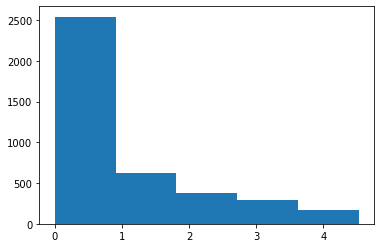

In [32]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5)
plt.show()

In [33]:
eigvals_bw01=[eigen_values[i] for i in range(len(eigen_values)) if eigen_values[i] <= 1]

In [34]:
eigvals_bw01

[-6.607119345005919e-16,
 -6.439180419954307e-16,
 -6.072185219458614e-16,
 -4.737396572466803e-16,
 -4.45655538287906e-16,
 -3.7758369608574855e-16,
 -3.5567707085390355e-16,
 -3.38002861470039e-16,
 -2.711569173196744e-16,
 -9.539104281784001e-17,
 2.1914319258118894e-16,
 0.008570241233118316,
 0.03824641787060256,
 0.12902594770769357,
 0.19198276544166928,
 0.22146632366779717,
 0.24860878491628394,
 0.26574940206431846,
 0.29743544459761045,
 0.3761885590372405,
 0.47694790355566524,
 0.5224496709372952,
 0.6522694792326317,
 0.6859560117544276,
 0.8428522769255645,
 0.9416334747678263,
 -5.79256084910146e-16,
 -4.968508624801472e-16,
 -4.0203485299460475e-16,
 -2.6680595672400525e-16,
 -2.3747331645358773e-16,
 -2.0998463740631415e-16,
 -2.263544954563617e-17,
 -1.6608138612732856e-17,
 2.5281468221711508e-17,
 3.2293662052058065e-17,
 2.3137128638920714e-16,
 0.006244625079441049,
 0.041605416685149166,
 0.09230200304313292,
 0.14223274965093122,
 0.19021679312157463,
 0.229375

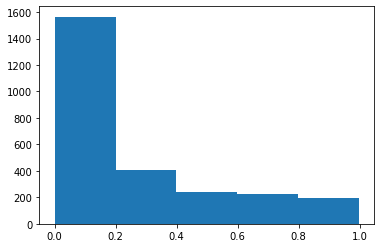

In [35]:
import matplotlib.pyplot as plt
plt.hist(eigvals_bw01, bins = 5)
plt.show()

In [36]:
eigen_values

[-6.607119345005919e-16,
 -6.439180419954307e-16,
 -6.072185219458614e-16,
 -4.737396572466803e-16,
 -4.45655538287906e-16,
 -3.7758369608574855e-16,
 -3.5567707085390355e-16,
 -3.38002861470039e-16,
 -2.711569173196744e-16,
 -9.539104281784001e-17,
 2.1914319258118894e-16,
 0.008570241233118316,
 0.03824641787060256,
 0.12902594770769357,
 0.19198276544166928,
 0.22146632366779717,
 0.24860878491628394,
 0.26574940206431846,
 0.29743544459761045,
 0.3761885590372405,
 0.47694790355566524,
 0.5224496709372952,
 0.6522694792326317,
 0.6859560117544276,
 0.8428522769255645,
 0.9416334747678263,
 1.0645253450856142,
 1.2095307069116792,
 1.293615189857623,
 1.5338355373025239,
 1.6495737427896802,
 1.7221301391564159,
 1.9065887202060061,
 2.1532915049278434,
 2.403173068272682,
 2.555395455871405,
 2.9207009459434,
 3.126292736047865,
 3.6590399992380953,
 3.9408694116267124,
 -5.79256084910146e-16,
 -4.968508624801472e-16,
 -4.0203485299460475e-16,
 -2.6680595672400525e-16,
 -2.37473316